# Develop negative log-likelihood with scaled inputs

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz

## Simulate measurements

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
delta = np.zeros(n)
alpha = np.zeros(m - 1)
eta = np.zeros(m - 1)

## Check gradient

In [3]:
logv = np.log(sigma**2)
scale_delta = thz.noiseamp(sigma, mu, ts)
_, grad_delta_tdnll = thz.tdnll(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=np.ones(n),
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

_, grad_delta_tdnll_scaled = thz.tdnll(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_delta_nd = nd.Gradient(
    lambda _delta: thz.tdnll(
        x,
        logv,
        _delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=np.ones(n),
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0],
    step=1e-6,
)(delta)

np.stack(
    (grad_delta_tdnll, grad_delta_tdnll_scaled / scale_delta, grad_delta_nd)
).T

array([[-1.78499301e+06, -1.78499301e+06, -1.78499136e+06],
       [ 3.34408331e+05,  3.34408331e+05,  3.34407730e+05],
       [-3.18976037e+06, -3.18976037e+06, -3.18975647e+06],
       [ 6.25507562e+03,  6.25507562e+03,  6.25536198e+03],
       [ 2.73178830e+06,  2.73178830e+06,  2.73178513e+06],
       [-7.20470280e+05, -7.20470280e+05, -7.20468844e+05],
       [-4.21790087e+06, -4.21790087e+06, -4.21789518e+06],
       [-2.82140739e+06, -2.82140739e+06, -2.82140365e+06],
       [ 2.53462945e+06,  2.53462945e+06,  2.53462625e+06],
       [ 4.91455018e+06,  4.91455018e+06,  4.91454464e+06],
       [ 1.68262230e+06,  1.68262230e+06,  1.68262022e+06],
       [ 5.52573815e+04,  5.52573815e+04,  5.52574262e+04],
       [ 8.62734944e+06,  8.62734944e+06,  8.62734033e+06],
       [ 1.29048234e+06,  1.29048234e+06,  1.29048127e+06],
       [ 5.01868231e+06,  5.01868231e+06,  5.01867727e+06],
       [ 2.79090884e+06,  2.79090884e+06,  2.79090620e+06],
       [ 1.27722077e+06,  1.27722077e+06

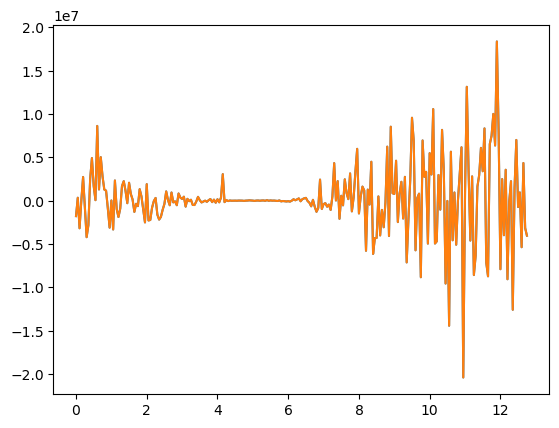

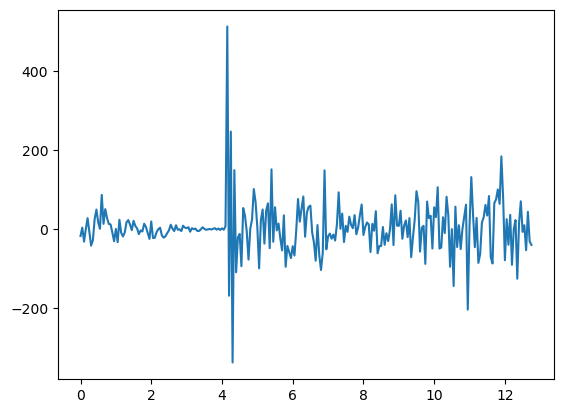

In [4]:
plt.plot(t, grad_delta_tdnll)
plt.plot(t, grad_delta_tdnll_scaled / scale_delta)
plt.show()
plt.plot(t, grad_delta_tdnll_scaled)
plt.show()

In [5]:
_, grad_logv_tdnll = thz.tdnll(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

scale_logv = 1e-1 * np.ones(3)
_, grad_logv_tdnll_scaled = thz.tdnll(
    x,
    logv / scale_logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_logv_nd = nd.Gradient(
    lambda _logv: thz.tdnll(
        x,
        _logv,
        delta,
        alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0]
)(logv)

np.stack(
    (grad_logv_tdnll, grad_logv_tdnll_scaled / scale_logv, grad_logv_nd)
).T

array([[-2257.71900912, -2257.71900912, -2257.71900912],
       [-1623.07622749, -1623.07622749, -1623.07622749],
       [  572.86859935,   572.86859935,   572.86859935]])

In [6]:
_, grad_alpha_tdnll = thz.tdnll(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=False,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_alpha_nd = nd.Gradient(
    lambda _alpha: thz.tdnll(
        x,
        logv,
        delta,
        _alpha,
        eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0]
)(alpha)

np.stack((grad_alpha_tdnll, grad_alpha_nd)).T

array([[ 6.14579370e+02,  6.14579370e+02],
       [ 4.25995097e+02,  4.25995097e+02],
       [ 3.66628809e+00,  3.66628811e+00],
       [ 5.30738008e+02,  5.30738008e+02],
       [ 9.60168835e+02,  9.60168835e+02],
       [ 1.94248475e+02,  1.94248475e+02],
       [-2.35733264e+02, -2.35733264e+02],
       [ 6.16109828e+02,  6.16109828e+02],
       [ 1.26372229e+02,  1.26372229e+02],
       [ 6.65283290e+02,  6.65283290e+02],
       [ 2.98736387e+02,  2.98736387e+02],
       [ 1.53145168e+03,  1.53145168e+03],
       [ 1.53666126e+03,  1.53666126e+03],
       [-3.27152519e+02, -3.27152519e+02],
       [-2.41295353e+02, -2.41295353e+02],
       [ 4.06611362e+02,  4.06611362e+02],
       [-2.71861290e+02, -2.71861290e+02],
       [ 1.66793339e+03,  1.66793339e+03],
       [ 4.14180499e+02,  4.14180499e+02],
       [ 8.16440035e+02,  8.16440035e+02],
       [ 1.34157812e+03,  1.34157812e+03],
       [ 2.05772588e+02,  2.05772588e+02],
       [ 6.54991588e+02,  6.54991588e+02],
       [ 1.

In [7]:
_, grad_eta_tdnll = thz.tdnll(
    x,
    logv,
    delta,
    alpha,
    eta,
    ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=False,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
)

grad_eta_nd = nd.Gradient(
    lambda _eta: thz.tdnll(
        x,
        logv,
        delta,
        alpha,
        _eta,
        ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
    )[0]
)(eta)

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[  -795.04396053,   -795.04396031],
       [ -6883.21798367,  -6883.21798319],
       [ -4706.06979223,  -4706.06979159],
       [ -5343.43384374,  -5343.43384297],
       [  2877.71965092,   2877.71965122],
       [  3092.40252588,   3092.40252651],
       [ -2625.95827617,  -2625.95827451],
       [   283.06649709,    283.06649779],
       [ -5308.90676356,  -5308.90676298],
       [  3675.37543623,   3675.37543657],
       [ -8567.44840419,  -8567.4484033 ],
       [-15555.67723072, -15555.67723029],
       [ -1245.75262593,  -1245.75262546],
       [ -4121.80219495,  -4121.80219423],
       [ -2790.39803099,  -2790.39803031],
       [ -9764.12992849,  -9764.12992808],
       [ 10775.91150961,  10775.91151042],
       [-12667.54041465, -12667.54041425],
       [  1350.23731845,   1350.23731982],
       [  -487.34890021,   -487.34889993],
       [ -5294.04831301,  -5294.04831249],
       [  5593.90543064,   5593.90543124],
       [-11634.43315983, -11634.43315844],
       [  -

## Estimate noise parameters with revised NLL

In [8]:
result = thz.tdnoisefit(x.T, ts=ts, fix_a=False, fix_eta=False)

In [9]:
print(result[2]["message"])

Optimization terminated successfully.


In [10]:
var_out = result[0]["var"] * m / (m - 1)
var_err = result[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 1.001e-10 ± 1.147e-09
Input: 0.0001	 Output: 9.723e-05 ± 0.002514
Input:  1e-06	 Output: 8.112e-07 ± 5.719e-05


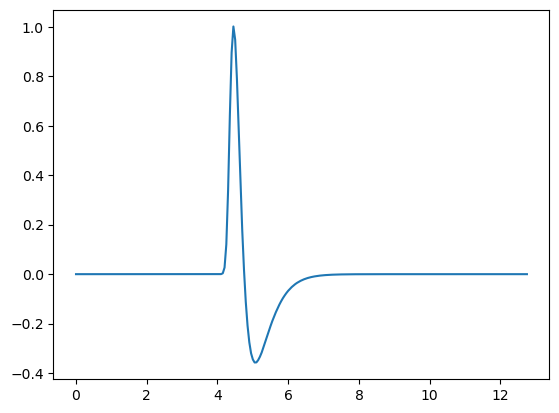

In [11]:
plt.plot(t, result[0]["mu"])
plt.show()

In [12]:
np.mean(np.var(x.T, 1))

3.013773582254218e-06

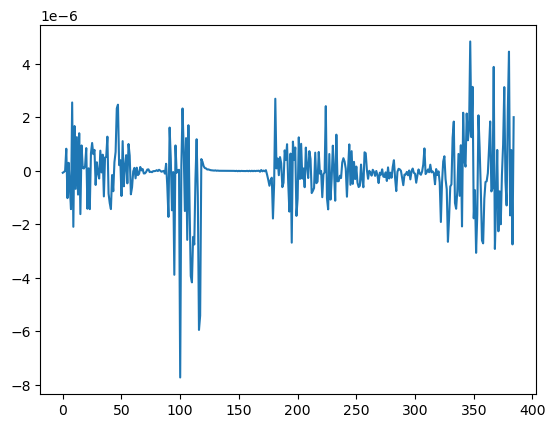

In [13]:
plt.plot(result[2]["grad"])
plt.show()